In [1]:
# 2017-10-05 LSTM

In [2]:
from __future__ import division
import sys, os, datetime
import pandas as pd
from collections import Counter
import functools
#import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as skm
import sklearn.model_selection as skms
import pymorphy2

In [3]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras.preprocessing.text
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [4]:
#dftrain, dftest = pd.read_csv("../Data/train_task1_latest.csv"), pd.read_csv("../Data/test_task1_latest.csv")
dftrain, dftest = pd.read_csv("../Work/train_task1_lemma.csv"), pd.read_csv("../Work/test_task1_lemma.csv")

In [5]:
dftrain.shape, dftest.shape, dftrain.columns

((119398, 13),
 (74294, 12),
 Index([u'paragraph_id', u'question_id', u'paragraph', u'question', u'target',
        u'paragraphL', u'questionL', u'paragraphLS', u'questionLS',
        u'paragraphLX', u'questionLX', u'paragraphLSX', u'questionLSX'],
       dtype='object'))

In [428]:
num_rows  = 1000 #len(dftrain) #10000 #00
train_x0  = dftrain.paragraphLS[:num_rows].tolist()
train_x1  = dftrain.questionLS[:num_rows].tolist()
xxx = []
for xx in train_x1 :
    xxx.append(' '.join([ss.encode('utf-8') for ss in re.findall("\w+", xx.decode('utf-8'),re.UNICODE) if len(ss)>=3]))
#print(train_x1[:2])
#print(xxx[:2])
#print([xx for xx in xxx if xx in None])
train_x1 = xxx
train_y   = dftrain.target[:num_rows]
train_voc = train_x1 #+train_x0
tokens = keras.preprocessing.text.Tokenizer(num_words=1000)
xx = tokens.fit_on_texts(train_voc)

train_x0 = tokens.texts_to_matrix(train_x0, mode='binary')  #, mode='tfidf')
train_x1 = tokens.texts_to_matrix(train_x1, mode='binary')  #, mode='tfidf')
'''
train_x0 = tokens.sequences_to_matrix(train_x0, mode='binary')  #, mode='tfidf')
train_x1 = tokens.sequences_to_matrix(train_x1, mode='binary')  #, mode='tfidf')
'''
print train_x0.shape, train_x1.shape, '\n\n', train_x0[:4,:6], '\n\n', train_x1[:4,:6]
print  '\nx0-sum={} x1-sum={} all0={:.4f}'.format(train_x0.sum(),train_x1.sum(), 1.0-float(train_y.sum())/len(train_y))

train_yy = np.array([train_y.values,train_y.values]).T
train_yy[:,0] = 1.0-train_yy[:,1]

train_yy.shape, train_yy[:100,0]


#tokens.__dict__
len(tokens.word_counts), '\n', train_x0.sum(axis=1), train_x1.sum(axis=1), (train_x0*train_x1).sum(axis=1), train_y.values
#for tt,xx in zip(tokens.word_counts.keys()[:55],tokens.word_counts.values()[:55]) : print xx,tt

(1000, 1000) (1000, 1000) 

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]] 

[[ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]

x0-sum=23008.0 x1-sum=5159.0 all0=0.7340


(4185,
 '\n',
 array([ 18.,  16.,  16.,  16.,  22.,  31.,  27.,  32.,  26.,  27.,  37.,
         21.,  16.,  41.,  22.,  21.,  23.,  24.,  18.,  30.,  21.,  37.,
         18.,  20.,  30.,  35.,  20.,  17.,  28.,  24.,  22.,  17.,  30.,
         15.,  24.,  16.,  19.,  32.,  26.,  24.,  20.,  29.,  20.,  27.,
         33.,  22.,  30.,  17.,  20.,  28.,  30.,  19.,  27.,  12.,  29.,
         23.,  35.,  16.,  28.,  13.,  14.,  20.,  25.,  26.,  33.,  20.,
         29.,  30.,  24.,  16.,  22.,  16.,  15.,  23.,  22.,  22.,  29.,
         27.,  29.,  22.,  20.,  16.,  16.,  22.,  12.,  24.,  22.,  17.,
         25.,  16.,  20.,  19.,  33.,  33.,  13.,  27.,  23.,  21.,  16.,
         16.,  28.,  20.,  17.,  28.,  40.,  27.,  18.,  17.,  30.,  19.,
         14.,  16.,  20.,  20.,  19.,  29.,   7.,  14.,  14.,  29.,  12.,
         12.,  29.,  19.,  22.,  18.,  16.,  12.,  25.,  12.,  35.,  30.,
         18.,  16.,  22.,  17.,  19.,  31.,  23.,  29.,  29.,  22.,  19.,
         23.,  22.,  38.

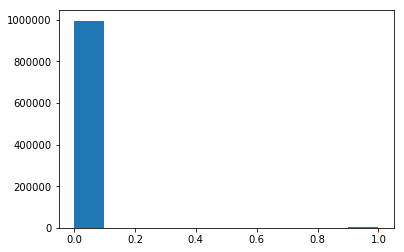

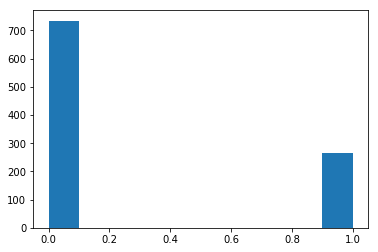

In [429]:
#train_x1.sum()
plt.hist(train_x1.flatten()); plt.show()
plt.hist(train_y.values.flatten()); plt.show()

In [433]:
import keras.layers.merge
max_features = train_x0.shape[1]
#model = Sequential()
#model.add(Embedding(max_features, 256))
#model.add(Input(shape=[max_feature], dtype='float32'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True,input_shape=[None,6]))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(5, activation='sigmoid'))

K.clear_session()

i0 = Input(shape=[max_features]) #, dtype='float32')
x0 = Embedding(max_features, 16)(i0)
x0 = LSTM(128,dropout=0.2)(x0)

i1 = Input(shape=[max_features]) #, dtype='float32')
x1 = Embedding(max_features, 8)(i1)
x1 = LSTM(128,dropout=0.2)(x1)

#xx = keras.layers.concatenate([x0, x1])
xx = keras.layers.Add()([x0, x1])

xx = Dense(16, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
xx = Dense(64, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(128, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
##xx = Dense(256, activation='relu')(xx)
xx = Dropout(0.25)(xx)
o = Dense(2, activation='softmax')(xx)
#o = Dense(1, activation='sigmoid')(xx)

model = Model(inputs=[i0,i1], outputs=o)

model.summary()

model.compile(loss='binary_crossentropy', #'mae', #'mse', #'binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy','mse'])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1000, 16)      16000       input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1000, 8)       8000        input_2[0][0]                    
___________________________________________________________________________________________

In [383]:
max_features = train_x0.shape[1]
#model = Sequential()
#model.add(Embedding(max_features, 256))
#model.add(Input(shape=[max_feature], dtype='float32'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True,input_shape=[None,6]))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(5, activation='sigmoid'))

K.clear_session()

i0 = Input(shape=[max_features]) #, dtype='float32')
x0 = Embedding(max_features,16)(i0)
x0,state_h,state_c = LSTM(16,dropout=0.2,return_state=True)(x0)

i1 = Input(shape=[max_features]) #, dtype='float32')
x1 = Embedding(max_features, 16)(i1)
xx,_,_ = LSTM(16,dropout=0.2,return_state=True)(x1,initial_state=[state_h,state_c])

#xx = keras.layers.concatenate([x0, x1])

#xx = Dense(128, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(64, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(32, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(16, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
xx = Dense(128, activation='relu')(xx)
xx = Dropout(0.25)(xx)
##xx = Dense(256, activation='relu')(xx)
###xx = Dropout(0.25)(xx)
o = Dense(2, activation='softmax')(xx)
#o = Dense(1, activation='sigmoid')(xx)

model = Model(inputs=[i0,i1], outputs=o)

model.summary()

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=0.3)
model.compile(loss='binary_crossentropy', #'mae', #'mse', #'binary_crossentropy',
              optimizer='RMSprop', #sgd, #'adam',
              metrics=['binary_accuracy','accuracy','mse'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1000, 16)      16000       input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1000, 16)      16000       input_2[0][0]                    
___________________________________________________________________________________________

In [435]:
batch_size   = 128  #128 #256 #512 #1024 #+512 #+1024 #+512
print (datetime.datetime.now())

reduce_lr1     = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=2, min_lr=0.0000001,verbose=1)
early_stopping = EarlyStopping(monitor='loss', patience=10,min_delta=0.0001,verbose=1)

#filepath="../Temp/TempTempG5M5KFold2/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
#checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')

hist = model.fit([train_x0,train_x1], train_yy,
                  batch_size=batch_size,
                  #shuffle=True,
                  epochs=10,
                  initial_epoch=0,
                  callbacks=[reduce_lr1],
                  #validation_data=([x_train[-200:],z_train[-200:],a_train[-200:]], y_train[-200:]),
                  verbose=2)
print (datetime.datetime.now())

2017-10-07 21:24:11.951716
Epoch 1/10
16s - loss: 0.5965 - binary_accuracy: 0.7340 - mean_squared_error: 0.2023
Epoch 2/10
16s - loss: 0.5825 - binary_accuracy: 0.7340 - mean_squared_error: 0.1967
Epoch 3/10
16s - loss: 0.5834 - binary_accuracy: 0.7340 - mean_squared_error: 0.1969
Epoch 4/10
16s - loss: 0.5805 - binary_accuracy: 0.7340 - mean_squared_error: 0.1958
Epoch 5/10
16s - loss: 0.5826 - binary_accuracy: 0.7340 - mean_squared_error: 0.1966
Epoch 6/10
16s - loss: 0.5850 - binary_accuracy: 0.7340 - mean_squared_error: 0.1976
Epoch 7/10

Epoch 00006: reducing learning rate to 0.000500000023749.
16s - loss: 0.5808 - binary_accuracy: 0.7340 - mean_squared_error: 0.1958
Epoch 8/10
16s - loss: 0.5804 - binary_accuracy: 0.7340 - mean_squared_error: 0.1957
Epoch 9/10
16s - loss: 0.5839 - binary_accuracy: 0.7340 - mean_squared_error: 0.1971
Epoch 10/10
16s - loss: 0.5819 - binary_accuracy: 0.7340 - mean_squared_error: 0.1963
2017-10-07 21:26:54.833149


In [405]:
#hist.__dict__

In [406]:
train_xp = model.predict([train_x0[:num_rows],train_x1[:num_rows]],batch_size=batch_size)

In [407]:
skm.accuracy_score(train_yy[:num_rows],train_xp>0.5), skm.roc_auc_score(train_yy[:num_rows],train_xp)

(0.69999999999999996, 0.5)

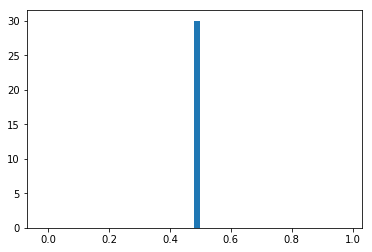

In [408]:
train_xp[:,1].sum()
hh=plt.hist(train_xp[:,1].flatten(),bins=50); plt.show()

In [409]:
hh

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  30.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ -1.98198259e-02,   1.80174112e-04,   2.01801741e-02,
          4.01801741e-02,   6.01801741e-02,   8.01801741e-02,
          1.00180174e-01,   1.20180174e-01,   1.40180174e-01,
          1.60180174e-01,   1.80180174e-01,   2.00180174e-01,
          2.20180174e-01,   2.40180174e-01,   2.60180174e-01,
          2.80180174e-01,   3.00180174e-01,   3.20180174e-01,
          3.40180174e-01,   3.60180174e-01,   3.80180174e-01,
          4.00180174e-01,   4.20180174e-01,   4.40180174e-01,
          4.60180174e-01,   4.80180174e-01,   5.00180174e-01,
          5.20180174e-01,   5.40180174e-01,   5.60180174e-01,
          5.80180174e-01,   6.00180174

In [410]:
len(tokens.word_counts), '\n', train_x0.sum(axis=1), train_x1.sum(axis=1), (train_x0*train_x1).sum(axis=1), train_y.values, train_xp[:,1]


(269,
 '\n',
 array([  7.,   8.,   7.,   4.,  19.,   9.,  10.,  16.,  17.,  10.,  35.,
         10.,  12.,  14.,   6.,  22.,   4.,  14.,   6.,  15.,   5.,  32.,
         23.,  17.,  12.,  12.,  14.,  13.,  25.,  17.]),
 array([ 12.,  18.,  16.,   8.,   5.,  12.,   8.,   8.,  10.,   7.,  14.,
         11.,   7.,  14.,  13.,   6.,   6.,   5.,  17.,   5.,   8.,  10.,
         15.,   9.,   7.,   9.,   9.,   3.,   8.,  14.]),
 array([  0.,   0.,   2.,   0.,   3.,   1.,   2.,   7.,  11.,   0.,  31.,
          0.,   8.,   3.,   0.,  12.,   1.,   4.,   0.,   1.,   2.,  13.,
         23.,   7.,   3.,   1.,   0.,   4.,  11.,   0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.]),
 array([ 0.48018017,  0.48018017,  0.48018017,  0.48018017,  0.48018017,
         0.48018017,  0.48018017,  0.48018017,  0.48018017,  0.48018017,
         0.48018017,  0.48018017,  0.48018017, 

In [184]:
import nltk, re
xx = dftrain.paragraphLS[:num_rows].tolist()
#print(type(xx),unicode(xx[0],'utf-8'))

##ff=nltk.probability.FreqDist(xx[0].decode('utf-8'))
##ff=nltk.probability.FreqDist(unicode(xx[0],'utf-8'),unicode_)

ff=nltk.probability.FreqDist()

for ss in xx :
    for ww in re.findall("\w+", ss.decode('utf-8'),re.UNICODE) :
        ff[ww] +=1


#for ww,cc in ff.most_common(50) : print(ww,cc)

In [181]:
for ww,cc in ff.most_common(50) :
    print ww,cc

год 134808
который 84027
свой 59027
это 55298
время 46071
мочь 40857
также 33663
весь 33155
являться 28849
её 27409
система 25191
человек 25005
например 23112
опера 22024
вид 21269
стать 19141
форма 19004
иметь 18984
век 18482
образ 18071
ещё 17594
друг 17112
новый 17066
французский 16918
некоторый 16481
течение 16471
часть 16230
большой 16189
отношение 15804
мир 14612
язык 14559
отец 14396
команда 14138
страна 13909
право 13904
использоваться 13754
иван 13682
сын 13438
фильм 13414
высокий 13341
4 13260
1 13211
несколько 13026
ряд 12871
разум 12618
двигатель 12602
называть 12460
самый 12431
писатель 12080
происходить 11915
